## Baseline Modeling for predictiong Learning Loss - Reading ##

The baseline models are:
- Ridge Regression
- SVM (Linear, Kernel)
- KNN
- Random Forest
- Grandient Boosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import warnings 
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Data_Integration.ipynb](../processing/Data_Integration.ipynb) and [EDA.ipynb](../processing/EDA.ipynb)

In [3]:
df = pd.read_csv('../processing/DATA_Texas_District_v5.csv', sep=',', header=0)
print(df.shape)

(979, 126)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(979, 137)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Students Tested Math - Grade 3 2018-2019',
            '% Students Tested Math - Grade 4 2018-2019',
            '% Students Tested Math - Grade 5 2018-2019',
            '% Students Tested Math - Grade 6 2018-2019',
            '% Students Tested Math - Grade 7 2018-2019',
            '% Students Tested Math - Grade 8 2018-2019',
            '% Students Tested Math - Grade 3 2020-2021',
            '% Students Tested Math - Grade 4 2020-2021',
            '% Students Tested Math - Grade 5 2020-2021',
            '% Students Tested Math - Grade 6 2020-2021',
            '% Students Tested Math - Grade 7 2020-2021',
            '% Students Tested Math - Grade 8 2020-2021',
            'Average Score Math All Grade 3 2018-2019',
            'Average Score Math All Grade 4 2018-2019',
            'Average Score Math All Grade 5 2018-2019',
            'Average Score Math All Grade 6 2018-2019',
            'Average Score Math All Grade 7 2018-2019',
            'Average Score Math All Grade 8 2018-2019',
            'District #', 'County #']

y = df['Label_Reading'].values
X = df.drop(columns=labels + cols_drop).values
columns = df.drop(columns=labels + cols_drop).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=123, shuffle=True)
print(X.shape)

(979, 114)


In [6]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,-1,180,45
1,0,416,104
2,1,187,47


**Normalization**

In [7]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
random_state=123
results = pd.DataFrame()

### Experiment with the Feature Sets selected from [Feature_Selection_Reading.ipynb](../processing/Feature_Selection_Reading.ipynb) ###

In [9]:
feature_selected = pd.read_csv('../Processing/Feature_Selection_Reading_Results.csv', sep=',', header=0)
feature_selected = feature_selected[feature_selected['selected']==1]
methods = feature_selected.Method.unique().tolist() + ["No Reduction"]

for n, m in enumerate(methods):
    n_feat = len(columns) if m == "No Reduction" else feature_selected[feature_selected['Method']==m].shape[0]
    print('Feature Set {}: n={} from {}'.format(n+1, n_feat, m))

Feature Set 1: n=13 from Variance Threshold
Feature Set 2: n=56 from Regularization - Lasso
Feature Set 3: n=57 from Feature Importance - Random Forest
Feature Set 4: n=36 from Permutation Importance - Random Forest
Feature Set 5: n=64 from Permutation Importance - Ridge
Feature Set 6: n=1 from RFE - Ridge
Feature Set 7: n=84 from RFE - Random Forest
Feature Set 8: n=57 from SFS - KNN
Feature Set 9: n=57 from SFS - Ridge
Feature Set 10: n=114 from No Reduction


### Modeling ###

In [10]:
def model_report(estimator, param_grid, name):
    result = pd.DataFrame()
    avg = 'weighted'   
       
    grid = GridSearchCV(estimator, param_grid=param_grid, cv=10, n_jobs=-1)
    
    for method in methods:
        features = columns if method == "No Reduction" else feature_selected[feature_selected['Method']==method]['feature'].unique().tolist()
        
        index = np.argwhere(np.isin(columns, features))
        X_train2 = X_train[:, index.flatten()]
        X_test2 = X_test[:, index.flatten()]
       
        t_start = time.process_time()
        grid.fit(X_train2, y_train)
        train_time = time.process_time() - t_start
        y_pred = grid.best_estimator_.predict(X_test2)
        temp = {'Model': name,
                'Method': method,
                'n Selected': int(index.shape[0]),
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'F1': f1_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'features': features,
                'estimator': grid.best_estimator_,
                'Train Time': train_time,
                'classification_report': classification_report(y_test, y_pred)}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

**Ridge Regression**

In [11]:
%%time
from sklearn.linear_model import LogisticRegression

params={'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
        
estimator=LogisticRegression(penalty='l2', n_jobs=-1, random_state=random_state, max_iter=10000, multi_class='ovr')
result=model_report(estimator, params, 'Ridge')
results=pd.concat([results, result], ignore_index=True)

CPU times: total: 6.38 s
Wall time: 3min 30s


**SVM**

In [12]:
%%time
from sklearn.svm import SVC

# params={'C': [0.01, 0.1, 1, 10],
#         'kernel': ['linear', 'rbf']}

params={'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf']}
        
estimator=SVC(random_state=random_state, probability=True, decision_function_shape='ovr')
result=model_report(estimator, params, 'SVM')
results=pd.concat([results, result], ignore_index=True)

CPU times: total: 6.27 s
Wall time: 22min


**KNN**

In [13]:
%%time
from sklearn.neighbors import KNeighborsClassifier

# params = {'n_neighbors': [1,3,5,7,9,11]}
params = {'n_neighbors': [1,3,5,7,9,11],
          'algorithm': ['ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10, 30, 50]}
          
estimator=KNeighborsClassifier(n_jobs=-1)
result=model_report(estimator, params, 'KNN')
results=pd.concat([results, result], ignore_index=True)

CPU times: total: 6.94 s
Wall time: 11.5 s


**Random Forest**

In [14]:
%%time
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [1, 6, None],
          'n_estimators': [50, 100, 200],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [1, 5, 10],    
          'max_samples': [0.1, 0.5, None],
          'max_leaf_nodes': [10, 31, None],
          'ccp_alpha': [0, 0.001, 0.1]}
          
estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1)
result=model_report(estimator, params, 'RF')
results=pd.concat([results, result], ignore_index=True)

CPU times: total: 3min 49s
Wall time: 1h 10min 56s


**Gradient Boosting**

In [15]:
%%time
from sklearn.ensemble import GradientBoostingClassifier


params = {'learning_rate': [0.1, 0.2, 0.3],
           'n_estimators': [50, 100, 200],
           'min_samples_leaf': [1, 5, 10],
           'min_weight_fraction_leaf': [0.0, 0.1, 0.5],
           'max_depth': [1, 3, 6], 
           'max_leaf_nodes': [10, 31, None],
           'ccp_alpha': [0, 0.001, 0.1]}


estimator=GradientBoostingClassifier(random_state=random_state, n_iter_no_change=20)
result=model_report(estimator, params, 'GB')
results=pd.concat([results, result], ignore_index=True)

CPU times: total: 5min 33s
Wall time: 2h 44min 7s


In [16]:
results.sort_values(by='MCC', ascending=False).to_csv('Modeling_BL_Reading.csv')

## Result  ##

In [17]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'Precision', 'Recall', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,Precision,Recall,MCC,F1,best_params
39,RF,No Reduction,114,0.637755,0.674443,0.637755,0.377057,0.570497,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep..."
43,GB,Permutation Importance - Random Forest,36,0.637755,0.653925,0.637755,0.367358,0.607185,"{'ccp_alpha': 0.001, 'learning_rate': 0.3, 'ma..."
37,RF,SFS - KNN,57,0.627551,0.637090,0.627551,0.353250,0.558079,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep..."
34,RF,Permutation Importance - Ridge,64,0.627551,0.631241,0.627551,0.352390,0.557489,"{'ccp_alpha': 0, 'criterion': 'entropy', 'max_..."
14,SVM,Permutation Importance - Ridge,64,0.622449,0.501047,0.622449,0.350689,0.529033,"{'C': 0.01, 'kernel': 'linear'}"
41,GB,Regularization - Lasso,56,0.627551,0.632230,0.627551,0.348296,0.604783,"{'ccp_alpha': 0, 'learning_rate': 0.3, 'max_de..."
46,GB,RFE - Random Forest,84,0.627551,0.624934,0.627551,0.347122,0.599529,"{'ccp_alpha': 0, 'learning_rate': 0.3, 'max_de..."
11,SVM,Regularization - Lasso,56,0.627551,0.633207,0.627551,0.345863,0.575849,"{'C': 1, 'kernel': 'rbf'}"
2,Ridge,Feature Importance - Random Forest,57,0.622449,0.617981,0.622449,0.338414,0.587706,"{'C': 0.1, 'solver': 'newton-cg'}"
42,GB,Feature Importance - Random Forest,57,0.622449,0.631205,0.622449,0.335555,0.567062,"{'ccp_alpha': 0.001, 'learning_rate': 0.1, 'ma..."


In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
GB,4
RF,3
SVM,2
Ridge,1


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
36,1
56,2
57,3
64,2
84,1
114,1


**Accuracy, MCC and F1 Score**

In [20]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

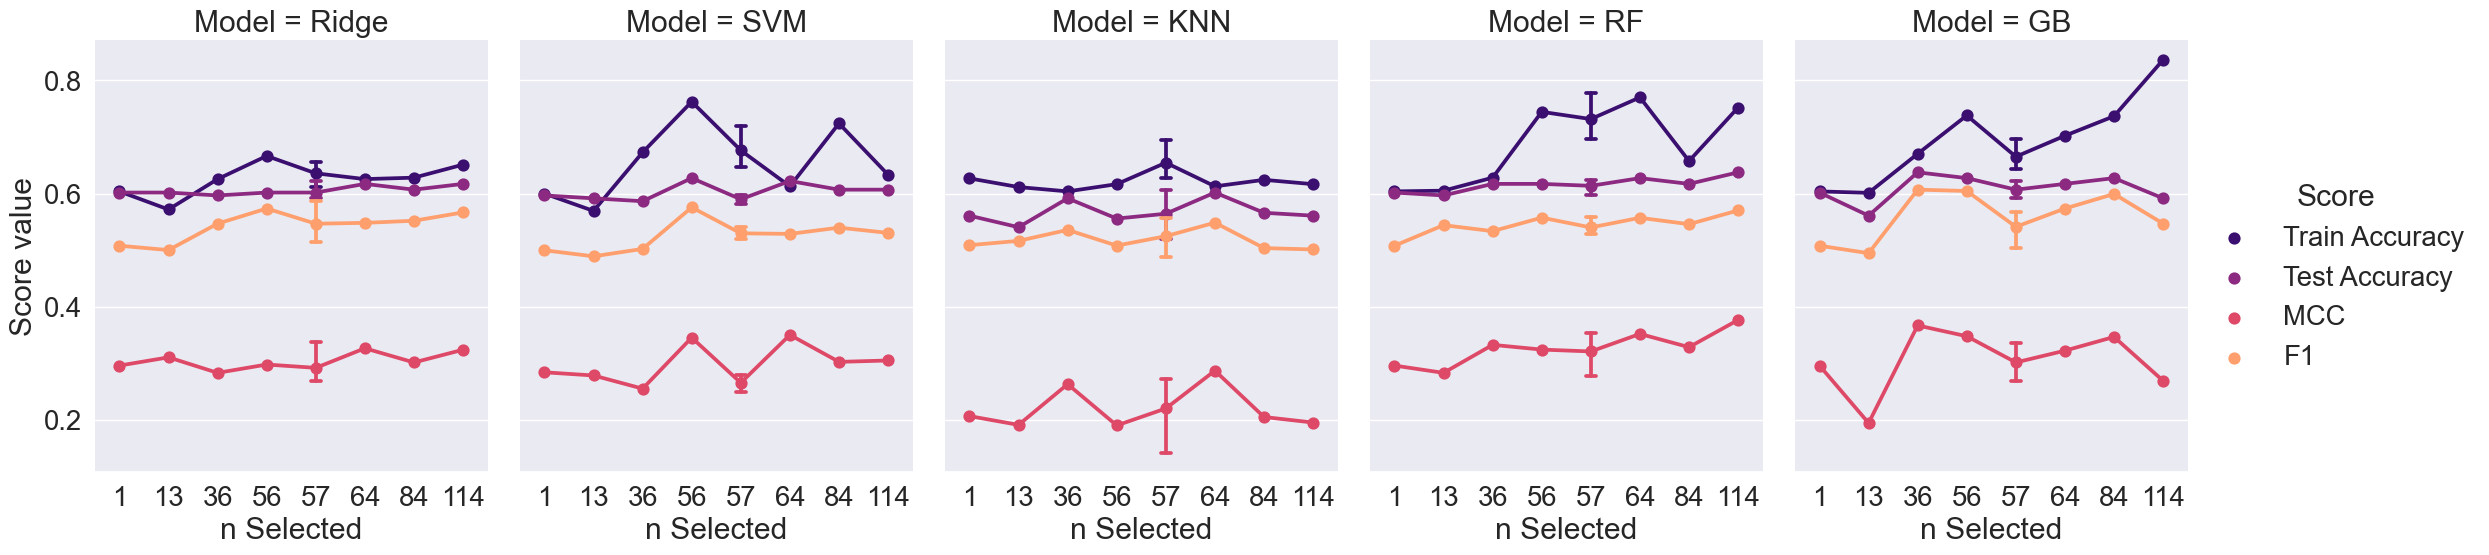

In [21]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [22]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

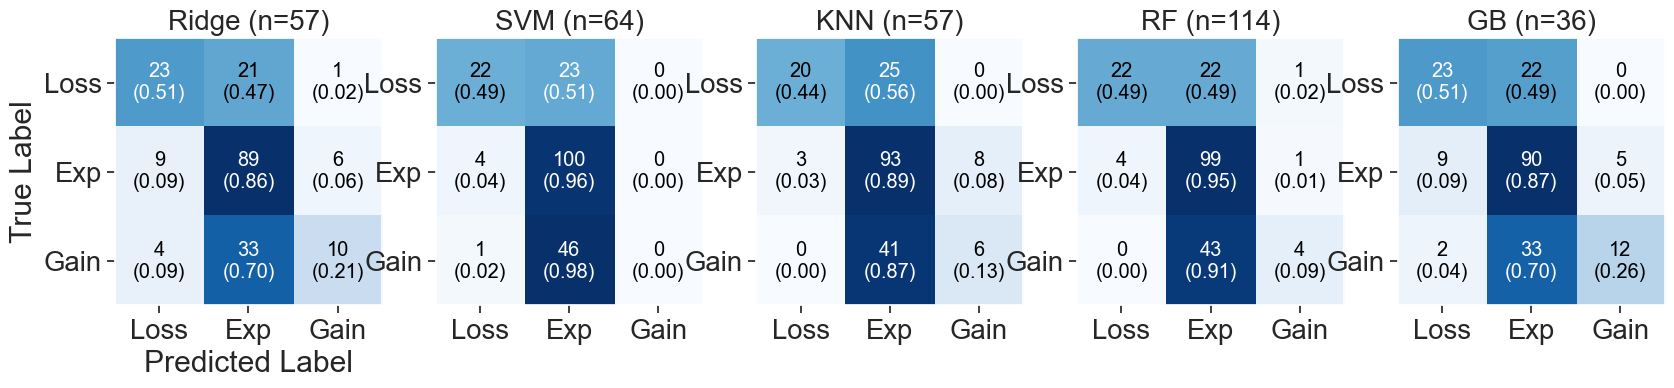

In [23]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

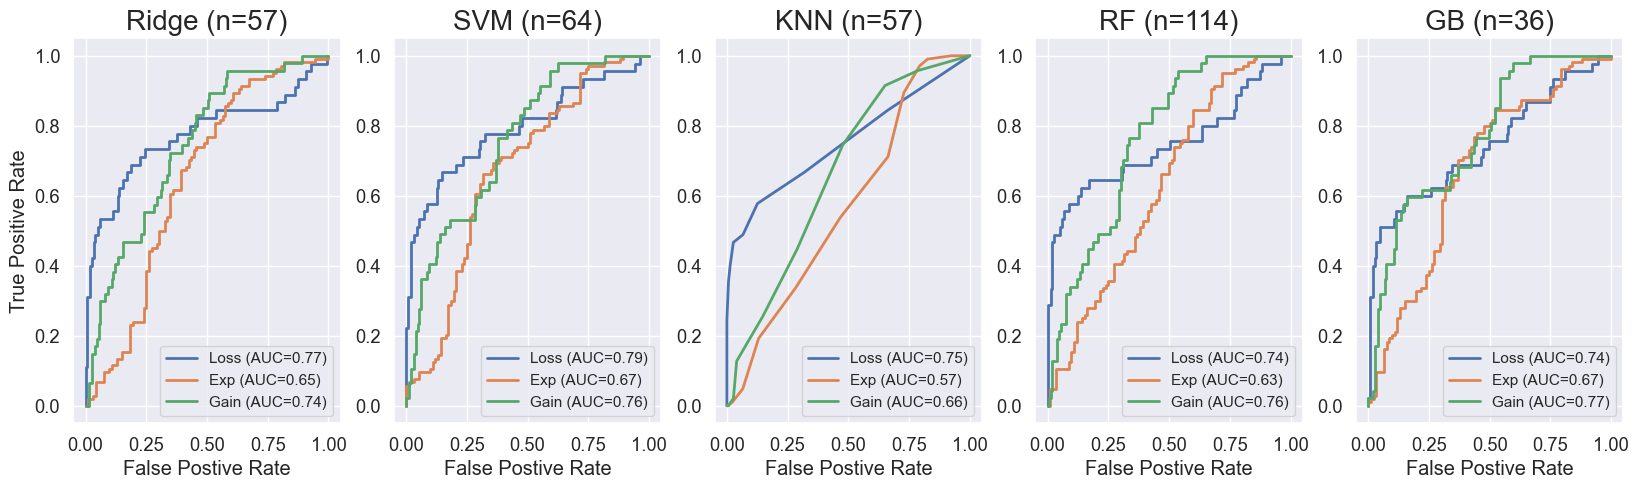

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[-1, 0, 1]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c+1], results.loc[idx, 'predict_proba'][:, c+1])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+2), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

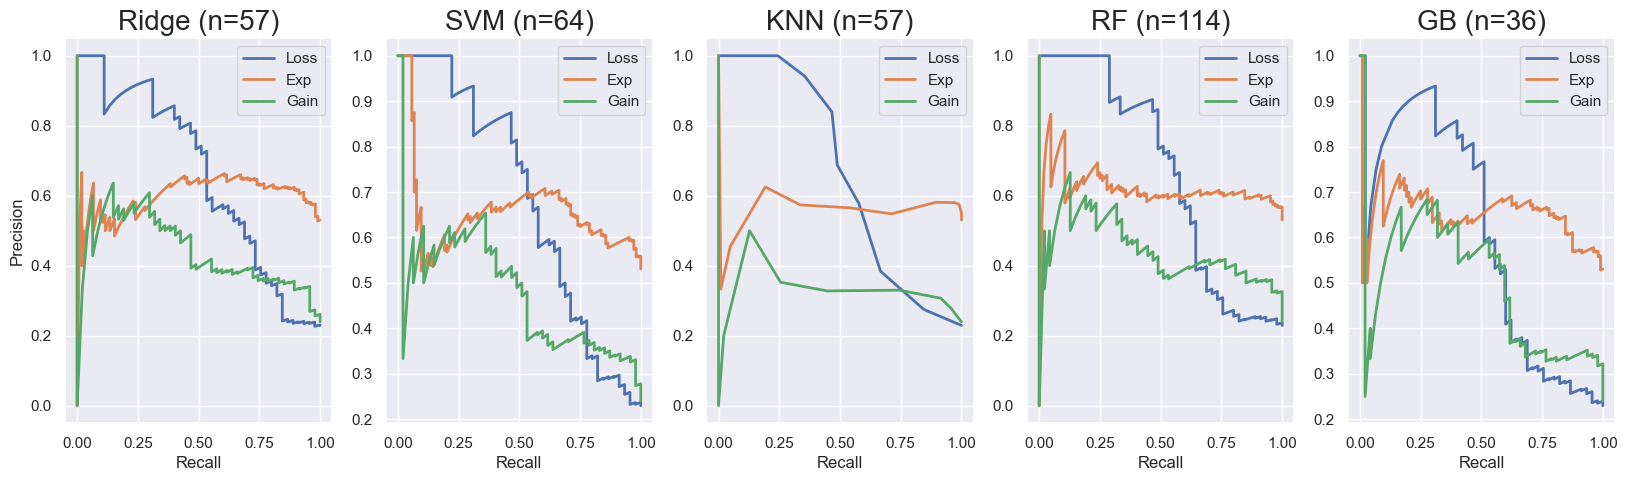

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[-1, 0, 1]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c+1], results.loc[idx, 'predict_proba'][:, c+1])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+2)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()